In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('C:\\Users\\Mulen\\OneDrive\\Documents\\Third Year\\Data Science\\CW1\\part_1\\N-BaIoT Dataset.csv')  # Update with the correct file path

In [3]:
# Step 1: Display dataset characteristics
print("Dataset Preview:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())

Dataset Preview:
   Flags  Protocol  Source Address  Source port  Direction  \
0  72293     72316           72527         1040      74083   
1  72288     72317           72527         1041      74087   
2  72288     72317           72527         1042      74087   
3  72304     72316           72527         1043      74083   
4  72304     72316           72527         1044      74083   

   Destination Address  Destination port  Total Packets  Total Bytes   State  \
0               112673              5678           1725      1275426  114225   
1                82205            114190              3          317  114222   
2                82205            114190              3          412  114222   
3               112673              5678             20         5506  114225   
4               110981            114212              4          248  114230   

   Labels  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Rang

In [4]:
# Preprocess the dataset
# Separate features (X) and labels (y)
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

In [5]:
# Check for class balance
unique, counts = np.unique(y, return_counts=True)
print("\nClass Distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")


Class Distribution:
Label 0: 158421 samples
Label 1: 153492 samples


In [6]:
# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Split into training (70%) and testing (30%) datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print("\nSplit Sizes:")
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Testing Set: {X_test.shape[0]} samples")


Split Sizes:
Training Set: 218339 samples
Testing Set: 93574 samples


In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Step 3: Define the neural network architecture
class BotnetClassifier(nn.Module):
    def __init__(self, input_size):
        super(BotnetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Initialize the model
input_size = X_train.shape[1]
model = BotnetClassifier(input_size)
print("\nNeural Network Architecture:")
print(model)


Neural Network Architecture:
BotnetClassifier(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [12]:
# Step 4: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training the model
epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

print("\nTraining Progress:")
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / len(train_loader.dataset))

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / len(test_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss = {train_losses[-1]:.4f}, Train Accuracy = {train_accuracies[-1]:.4f}, "
          f"Test Loss = {test_losses[-1]:.4f}, Test Accuracy = {test_accuracies[-1]:.4f}")


Training Progress:
Epoch 1/20: Train Loss = 0.0129, Train Accuracy = 0.9971, Test Loss = 0.0026, Test Accuracy = 0.9993
Epoch 2/20: Train Loss = 0.0021, Train Accuracy = 0.9995, Test Loss = 0.0015, Test Accuracy = 0.9998
Epoch 3/20: Train Loss = 0.0012, Train Accuracy = 0.9997, Test Loss = 0.0012, Test Accuracy = 0.9998
Epoch 4/20: Train Loss = 0.0010, Train Accuracy = 0.9998, Test Loss = 0.0010, Test Accuracy = 0.9998
Epoch 5/20: Train Loss = 0.0011, Train Accuracy = 0.9997, Test Loss = 0.0014, Test Accuracy = 0.9998
Epoch 6/20: Train Loss = 0.0008, Train Accuracy = 0.9998, Test Loss = 0.0009, Test Accuracy = 0.9998
Epoch 7/20: Train Loss = 0.0009, Train Accuracy = 0.9998, Test Loss = 0.0011, Test Accuracy = 0.9998
Epoch 8/20: Train Loss = 0.0007, Train Accuracy = 0.9998, Test Loss = 0.0012, Test Accuracy = 0.9998
Epoch 9/20: Train Loss = 0.0010, Train Accuracy = 0.9998, Test Loss = 0.0009, Test Accuracy = 0.9998
Epoch 10/20: Train Loss = 0.0006, Train Accuracy = 0.9998, Test Loss = 

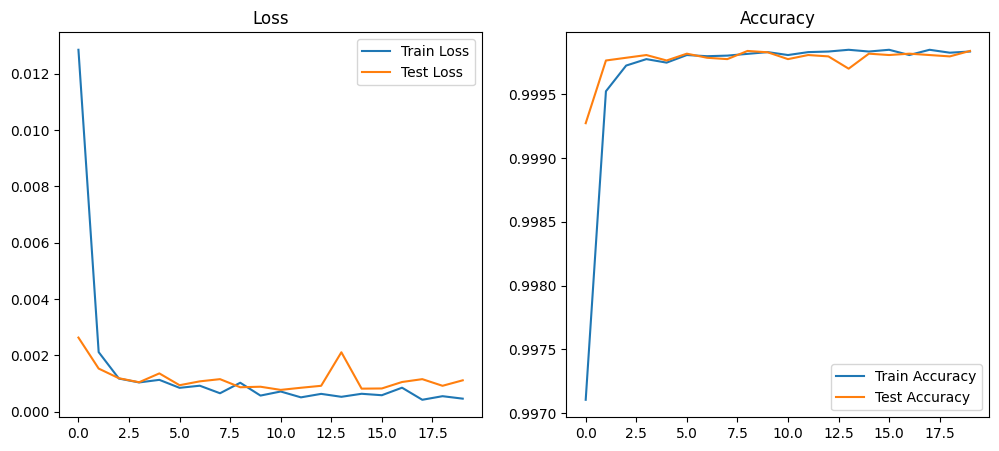

In [14]:
# Step 5: Plot training and testing performance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [15]:
# Step 6: Test on 5 random unseen samples
import random

model.eval()
test_indices = random.sample(range(len(X_test)), 5)
test_samples = X_test_tensor[test_indices]
true_labels = y_test[test_indices]

with torch.no_grad():
    predictions = model(test_samples)
    predicted_labels = torch.argmax(predictions, axis=1)

print("\nSample Predictions:")
for i, idx in enumerate(test_indices):
    print(f"Sample {i+1}: True Label = {true_labels[i]}, Predicted Label = {predicted_labels[i].item()}")


Sample Predictions:
Sample 1: True Label = 0, Predicted Label = 0
Sample 2: True Label = 0, Predicted Label = 0
Sample 3: True Label = 1, Predicted Label = 1
Sample 4: True Label = 1, Predicted Label = 1
Sample 5: True Label = 0, Predicted Label = 0
